In [2]:
from tensorflow.keras.preprocessing.text import Tokenizer
import pandas as pd
max_words = 5000
max_len = 500
tokenizer = Tokenizer(num_words=max_words)  ## 使用的最大詞語數為5000
news = pd.read_excel('ETtoday news_202205.xlsx', engine = 'openpyxl')
tokenizer.fit_on_texts(news['tokenization'])

## 使用word_index屬性可以看到每個詞對應的編碼
## 使用word_counts屬性可以看到每個詞對應的頻數
for index,item in enumerate(tokenizer.word_index.items()):
    if index < 10:
        print(item)
    else:
        break
print("===================")  
for index,item in enumerate(tokenizer.word_counts.items()):
    if index < 10:
        print(item)
    else:
        break
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
labelencoder = LabelEncoder()
le_y = labelencoder.fit_transform(news['category']).reshape(-1,1)
ohe = OneHotEncoder()
y = ohe.fit_transform(le_y).toarray()
x = news['tokenization']
#Split the data to have 20% validation split
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2)

from sklearn import metrics
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation, Dense, Dropout, Input, Embedding, GRU
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence

train_seq = tokenizer.texts_to_sequences(train_x)
test_seq = tokenizer.texts_to_sequences(test_x)
## 將每個序列調整相同的長度
train_seq_mat = sequence.pad_sequences(train_seq,maxlen=max_len)
test_seq_mat = sequence.pad_sequences(test_seq,maxlen=max_len)
# print(train_seq_mat.shape, test_seq_mat.shape)



('的', 1)
('是', 2)
('有', 3)
('在', 4)
('也', 5)
('一', 6)
('了', 7)
('就', 8)
('不', 9)
('都', 10)
('實習', 1708)
('記者', 8023)
('周依儒', 51)
('綜合', 3054)
('報導', 6132)
('晚上', 472)
('在', 24798)
('路', 641)
('邊', 1522)
('時', 5709)


In [3]:
inputs = Input(name='inputs',shape=[max_len])
## Embedding(詞匯表大小,vector長度,每個新聞的詞長)
layer = Embedding(max_words+1,128,input_length=max_len)(inputs)
layer = GRU(128)(layer)
layer = Dense(128,activation="relu",name="FC1")(layer)
layer = Dropout(0.3)(layer)
layer = Dense(3,activation="softmax",name="FC2")(layer)
model = Model(inputs=inputs,outputs=layer)
model.summary()
## multi-classification problem use categorical_crossentropy
model.compile(loss="categorical_crossentropy",optimizer=RMSprop(),metrics=["accuracy"])

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 500)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 500, 128)          640128    
_________________________________________________________________
gru (GRU)                    (None, 128)               99072     
_________________________________________________________________
FC1 (Dense)                  (None, 128)               16512     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
FC2 (Dense)                  (None, 3)                 387       
Total params: 756,099
Trainable params: 756,099
Non-trainable params: 0
________________________________________________

In [4]:
model_fit = model.fit(train_seq_mat,train_y,batch_size=128,epochs=10,
                      validation_split=0.2)


Epoch 1/10
36/36 [==============================] - 33s 915ms/step - loss: 0.5494 - accuracy: 0.8150 - val_loss: 0.2448 - val_accuracy: 0.8667
Epoch 2/10
36/36 [==============================] - 40s 1s/step - loss: 0.1396 - accuracy: 0.9568 - val_loss: 0.0749 - val_accuracy: 0.9877
Epoch 3/10
36/36 [==============================] - 40s 1s/step - loss: 0.0313 - accuracy: 0.9947 - val_loss: 0.0136 - val_accuracy: 0.9974
Epoch 4/10
36/36 [==============================] - 40s 1s/step - loss: 0.0165 - accuracy: 0.9939 - val_loss: 0.0111 - val_accuracy: 0.9965
Epoch 5/10
36/36 [==============================] - 38s 1s/step - loss: 0.0098 - accuracy: 0.9974 - val_loss: 0.0152 - val_accuracy: 0.9956
Epoch 6/10
36/36 [==============================] - 41s 1s/step - loss: 0.0016 - accuracy: 0.9993 - val_loss: 0.0091 - val_accuracy: 0.9974
Epoch 7/10
36/36 [==============================] - 40s 1s/step - loss: 1.0079e-04 - accuracy: 1.0000 - val_loss: 0.0084 - val_accuracy: 0.9974
Epoch 8/10
36

In [5]:
import numpy as np
test_pre = model.predict(test_seq_mat)
## evaluate the performance of prediction
confusion_matrix = metrics.confusion_matrix(np.argmax(test_pre,axis=1),np.argmax(test_y,axis=1))
print("Confusion matrix: \n",confusion_matrix)

scores = model.evaluate(test_seq_mat, test_y, verbose=0)
print("Out-of-sample loss: ", scores[0],"Out-of-sample accuracy:", scores[1])

print(metrics.classification_report(np.argmax(test_pre,axis=1),np.argmax(test_y,axis=1)))


Confusion matrix: 
 [[194   0   0]
 [  2 604   0]
 [  1   0 624]]
Out-of-sample loss:  0.008170878514647484 Out-of-sample accuracy: 0.9978947639465332
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       194
           1       1.00      1.00      1.00       606
           2       1.00      1.00      1.00       625

    accuracy                           1.00      1425
   macro avg       0.99      1.00      1.00      1425
weighted avg       1.00      1.00      1.00      1425



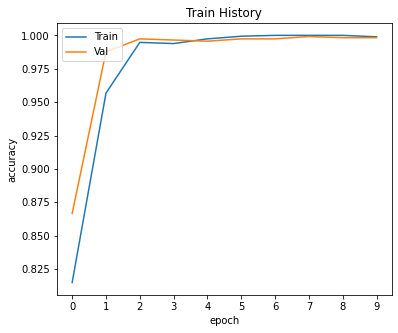

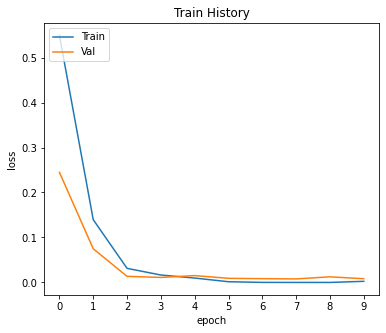

In [6]:

# 繪製歷程圖
import matplotlib.pyplot as plt
def show_train_history(train_history):
    plt.figure(figsize=(6,5))
    plt.plot(train_history.history['accuracy'])
    plt.plot(train_history.history['val_accuracy'])
    plt.xticks([i for i in range(len(train_history.history['accuracy']))])
    plt.title('Train History')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.savefig('Accuracy.png')
    plt.show()

    plt.figure(figsize=(6,5))
    plt.plot(train_history.history['loss'])
    plt.plot(train_history.history['val_loss'])
    plt.xticks([i for i in range(len(train_history.history['loss']))])
    plt.title('Train History')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.savefig('Loss.png')
    plt.show()
show_train_history(model_fit)
